In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = Path("/content/drive/MyDrive/data/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [4]:
print(len(filenames))
print(filenames[:3])

9009
['27_0_0_20170117175631490.jpg.chip.jpg', '27_0_1_20170113182853263.jpg.chip.jpg', '27_0_0_20170120220108816.jpg.chip.jpg']


# Data preprocessing

Data I have downloaded is composed of 23,708 images with age and gender in the Image Name. For Example, 1_0_0_239389.JPG image means that age is 1, gender is 0 (male) and 0 refers to the race (not needed in this task).
So I split the image name on ' _ ' so I can get separated age and gender with image.
Also, I have shuffle all the images

In [5]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [6]:
image_path

['1_1_0_20170109194244035.jpg.chip.jpg',
 '23_1_2_20170116173016687.jpg.chip.jpg',
 '22_1_4_20170103223356448.jpg.chip.jpg',
 '1_0_0_20161219205817093.jpg.chip.jpg',
 '21_1_2_20170116164805815.jpg.chip.jpg',
 '22_0_0_20170117140942783.jpg.chip.jpg',
 '23_1_2_20170116173154425.jpg.chip.jpg',
 '23_1_2_20170116173201790.jpg.chip.jpg',
 '22_0_2_20170116220743409.jpg.chip.jpg',
 '26_1_2_20170116180655987.jpg.chip.jpg',
 '24_1_0_20170116214224254.jpg.chip.jpg',
 '22_0_1_20170113133327736.jpg.chip.jpg',
 '25_1_1_20170116001921217.jpg.chip.jpg',
 '24_1_3_20170119164644510.jpg.chip.jpg',
 '1_0_4_20161221195827599.jpg.chip.jpg',
 '1_1_0_20170109193726686.jpg.chip.jpg',
 '16_0_3_20170116030352295.jpg.chip.jpg',
 '24_1_1_20170116224913775.jpg.chip.jpg',
 '27_1_2_20170116162537496.jpg.chip.jpg',
 '20_1_2_20170116182714846.jpg.chip.jpg',
 '25_0_3_20170117140649662.jpg.chip.jpg',
 '18_1_1_20170114030334837.jpg.chip.jpg',
 '18_0_1_20170113175821404.jpg.chip.jpg',
 '23_0_0_20170104004006925.jpg.chip.jp

# From Unstructured data to Structured data

In [7]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [8]:
df.head()

,image,age,gender
0,1_1_0_20170109194244035.jpg.chip.jpg,1,1
1,23_1_2_20170116173016687.jpg.chip.jpg,23,1
2,22_1_4_20170103223356448.jpg.chip.jpg,22,1
3,1_0_0_20161219205817093.jpg.chip.jpg,1,0
4,21_1_2_20170116164805815.jpg.chip.jpg,21,1


In [9]:
gender_dict = {0:"Male",1:"Female"}

In [10]:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [11]:
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


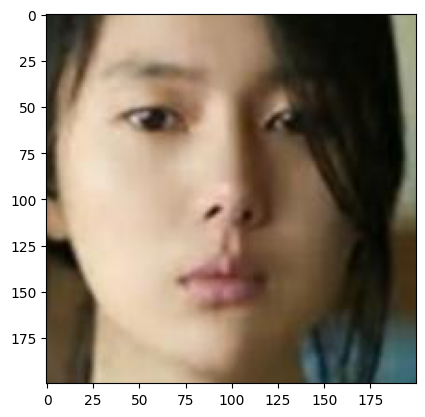

In [12]:
img = Image.open("/content/drive/MyDrive/data/UTKFace/"+df.image[1])
plt.imshow(img)

<ipython-input-13-36725a16e635>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<Axes: xlabel='age', ylabel='Density'>

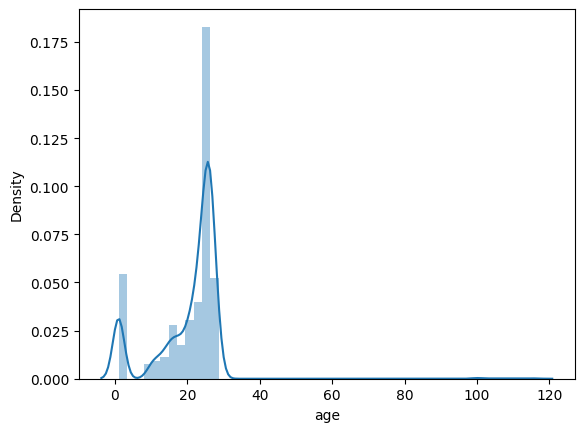

In [13]:
sns.distplot(df.age)

# Plotting Images

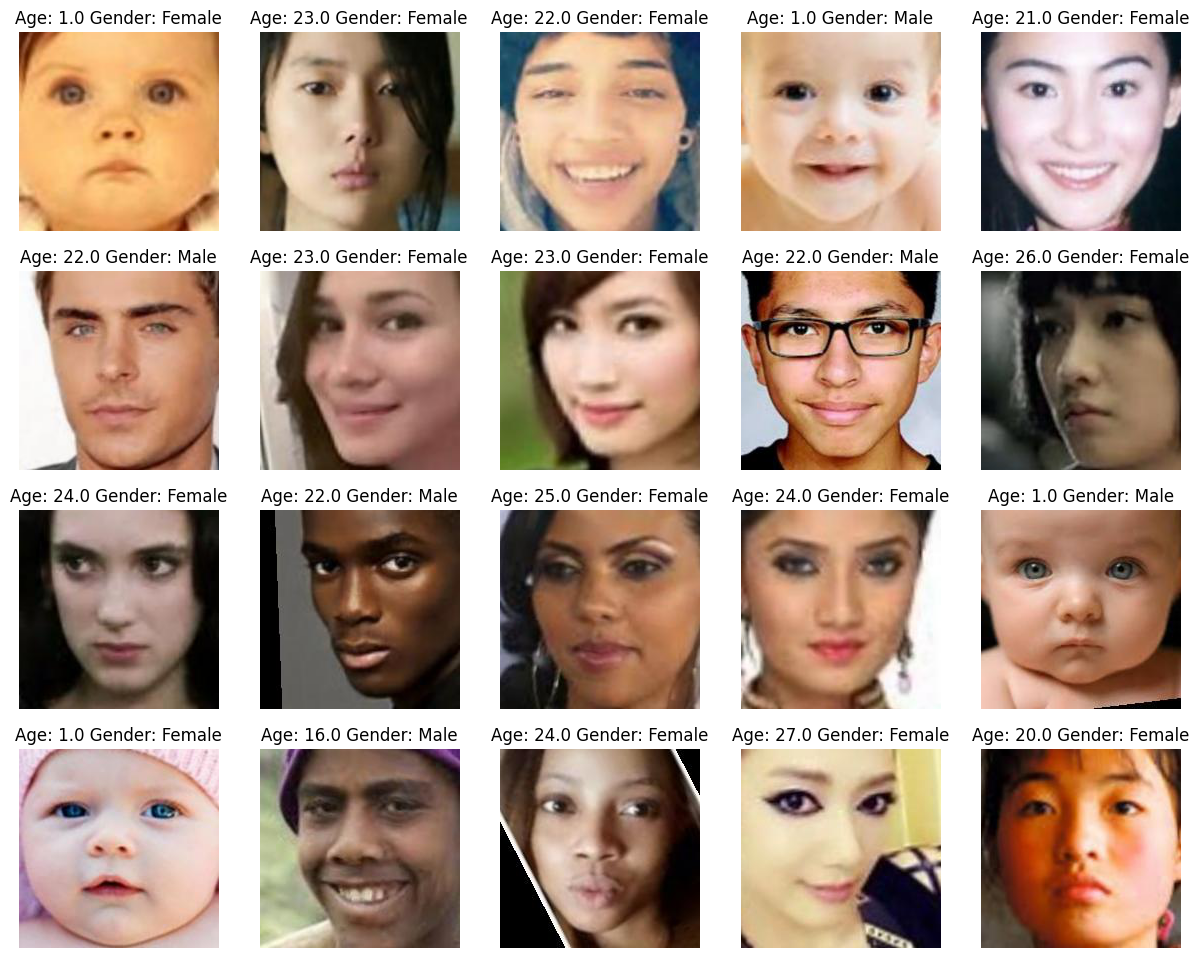

In [14]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/content/drive/MyDrive/data/UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

Since dataset is too large, It is taking a lot of time to train the model so I am splitting the data and only using half of the dataset. 
I have already shuffled all the data to ensure no biasness in the dataset.

In [15]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [16]:
train.head()

,image,age,gender
3642,25_1_1_20170112235102049.jpg.chip.jpg,25.0,1
3726,16_1_0_20170109213440225.jpg.chip.jpg,16.0,1
8601,27_1_4_20170103230557794.jpg.chip.jpg,27.0,1
5208,1_0_3_20161219225952240.jpg.chip.jpg,1.0,0
6609,18_1_3_20170119153619553.jpg.chip.jpg,18.0,1


# Extracting Features

In [17]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("/content/drive/MyDrive/data/UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

/usr/local/lib/python3.9/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [18]:
x_train.shape

(1351, 128, 128, 1)

# Normalizing data

In [19]:
x_train = x_train/255

In [20]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [21]:
input_size = (128,128,1)

# Creating model

In [26]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet101

SIZE = 128
N_ch = 1

def build_resnet():
    resnet = ResNet101(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output_1 = Dense(1, activation='sigmoid', name='gender_output')(x)
    output_2 = Dense(1, activation='relu', name='age_output')(x) 

    # model
    model = Model(input, outputs=[output_1, output_2])
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model


# Training the model

In [28]:
model = build_resnet()
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size=10, epochs=20, validation_split=0.1)


171446536/171446536 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 3)  30          ['input_2[0][0]']                
                                                                                                  
 resnet101 (Functional)         (None, None, None,   42658176    ['conv2d[0][0]']                 
                                2048)                                                             
                           

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
122/122 [==============================] - 589s 5s/step - loss: 17.8997 - gender_output_loss: 0.8365 - age_output_loss: 17.0632 - gender_output_accuracy: 0.6148 - age_output_accuracy: 0.0173 - val_loss: 20.8071 - val_gender_output_loss: 4.9404 - val_age_output_loss: 15.8667 - val_gender_output_accuracy: 0.5735 - val_age_output_accuracy: 0.1250
Epoch 2/20
122/122 [==============================] - 572s 5s/step - loss: 11.2244 - gender_output_loss: 0.8177 - age_output_loss: 10.4068 - gender_output_accuracy: 0.5770 - age_output_accuracy: 0.0173 - val_loss: 22.2572 - val_gender_output_loss: 0.8602 - val_age_output_loss: 21.3971 - val_gender_output_accuracy: 0.5735 - val_age_output_accuracy: 0.0000e+00
Epoch 3/20
122/122 [==============================] - 570s 5s/step - loss: 9.9620 - gender_output_loss: 0.7750 - age_output_loss: 9.1870 - gender_output_accuracy: 0.5786 - age_output_accuracy: 0.0535 - val_loss: 11.3996 - val_gender_output_loss: 0.6825 - val_age_output_loss: 10.717

# Visualizing loss

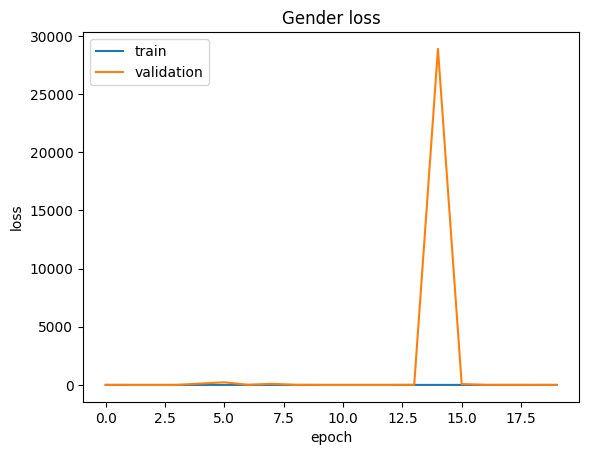

In [29]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

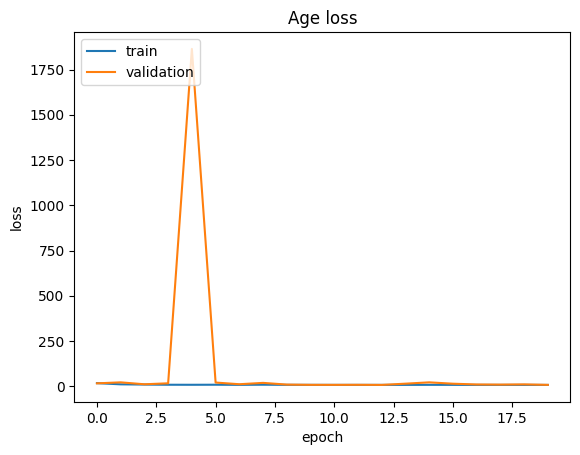

In [30]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicting test image

Original: Gender =  Male  Age =  11.0
1/1 [==============================] - 3s 3s/step
Prediction: Gender =  Female  Age =  23


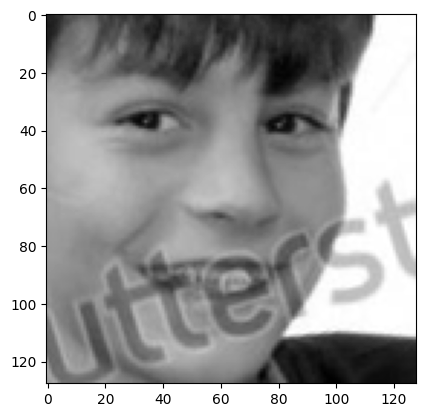

In [31]:
index=50
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

According to the loss, the model is overfitting. I should have add some more regularization in the model to prevent overfitting but it is taking a lot of time. With 5k images, it takes 2.5 hours to fit on the train set. I stopped here but you can try adding regularization techniques to prevent overfitting.

Original: Gender =  Female  Age =  23.0
1/1 [==============================] - 0s 147ms/step
Prediction: Gender =  Female  Age =  25


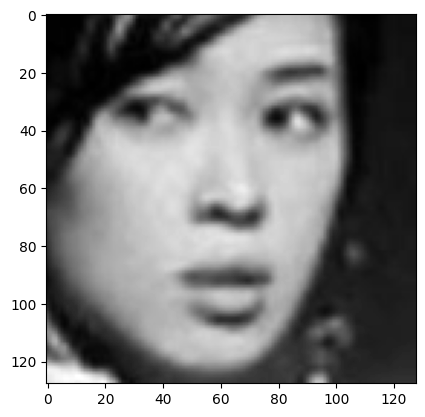

In [32]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')